# Survey Design figures

In [1]:
import os
import h5py
import sv as SV
import numpy as np
import astropy.table as atable

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
# load compiled zsuccess rates to file
dat_dir = '/global/cscratch1/sd/chahah/bgs-cmxsv/sv-paper/'
#dat_dir = '/Users/chahah/data/bgs_cmxsv/sv_paper/'

In [4]:
# read in spectral sim (source spectra)
source = h5py.File(os.path.join(dat_dir, 'GALeg.g15.sourceSpec.1000.seed0.hdf5'), 'r')
meta = {}
for k in ['r_mag_apflux', 'r_mag_gama', 'zred', 'absmag_ugriz']:
    meta[k] = source[k][...]
meta['r_mag'] = 22.5 - 2.5 * np.log10(source['legacy-photo']['flux_r'][...])
source.close()

In [5]:
# extract true redshift and r-band magnitude for the simulated galaxies
ztrue = meta['zred'] # redshift
r_mag = meta['r_mag'] # Legacy Survey r mag

In [6]:
def redrock_tnom(tnom, dchi2=15.): 
    frr = os.path.join(dat_dir, 'zbest.bgs_spectral_sim.nominal_dark.texp%.fs.fits' % tnom)
    rr = atable.Table.read(frr)
    
    dz_1pz = np.abs(ztrue - rr['Z']) / (1. + ztrue)

    crit_zdiff = (dz_1pz < 0.003)
    crit_zwarn = (rr['ZWARN'] == 0)
    crit_dchi2 = (rr['DELTACHI2'] > dchi2)
    
    return crit_zdiff & crit_zwarn & crit_dchi2

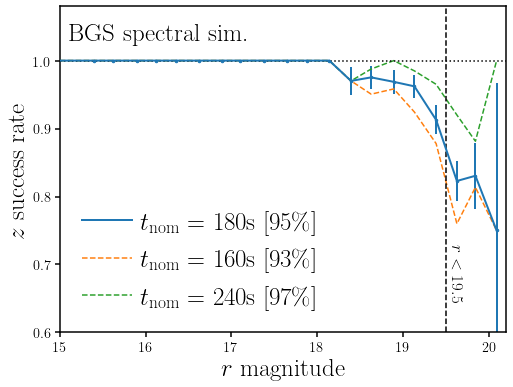

In [50]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

zsuccess = redrock_tnom(180., dchi2=40)   
fzs = (np.sum(zsuccess[r_mag < 19.5]) / np.sum(r_mag < 19.5))
zsuccess[r_mag < 18.] = True 

wmean, rate, err_rate = SV.zsuccess_rate(r_mag, zsuccess, range=(15, 22), nbins=28)
sub.errorbar(wmean, rate, err_rate, fmt='.C0', markersize=5, elinewidth=2)
sub.plot(np.concatenate([[15.], wmean]), np.concatenate([[1.], rate]), c='C0', lw=2, zorder=10, label=r'$t_{\rm nom}$ = '+'180s [{0:.0f}\%]'.format(100*fzs))

for i, exptime in enumerate([160, 240]): 
    # calculate redshift success rate
    zsuccess = redrock_tnom(exptime, dchi2=40)    
    fzs = (np.sum(zsuccess[r_mag < 19.5]) / np.sum(r_mag < 19.5))

    zsuccess[r_mag < 18.] = True # this is to account for the unusual bright z failures, which we think will eventually be ironed out
    wmean, rate, err_rate = SV.zsuccess_rate(r_mag, zsuccess, range=(15, 22), nbins=28)
    sub.plot(np.concatenate([[15.], wmean]), np.concatenate([[1.], rate]), c='C%i' % (i+1), ls='--', label=r'$t_{\rm nom}$ = '+'{0:d}s [${1:.0f}$\%]'.format(exptime, 100*fzs))

sub.axhline(1., color='k', linestyle=':')
sub.axvline(19.5, color='k', linestyle='--')
sub.text(19.52, 0.65, '$r < 19.5$', rotation=270, fontsize=17)


sub.text(0.02, 0.95, 'BGS spectral sim.', ha='left', va='top', transform=sub.transAxes, fontsize=25)
sub.legend(loc='lower left', fontsize=25, handletextpad=0.3)

sub.set_xlabel('$r$ magnitude', fontsize=25)
sub.set_xlim(15, 20.2)
sub.set_ylabel('$z$ success rate', fontsize=25)
sub.set_ylim(0.6, 1.08)

fig.savefig('figs/spectral_sims.pdf', bbox_inches='tight')

# save figure data to file

In [12]:
zsuccess_160 = redrock_tnom(160., dchi2=40)   
zsuccess_180 = redrock_tnom(180., dchi2=40)   
zsuccess_240 = redrock_tnom(240., dchi2=40)   

np.savetxt('dat/fig5_spectralsim_zsuccess.dat', 
           np.vstack([r_mag, zsuccess_180.astype(int), zsuccess_160.astype(int), zsuccess_240.astype(int)]).T, 
           fmt='%f %i %i %i', 
           header='Spectral simulation redshift success (1: z success, 0: z fail)\n r magnitude, z-success (tnom = 180s), z-success (tnom = 160s), z-success (tnom = 240s)')